# Absolute Calibration of HERA-19 Data

### Scripts
    absref_npz_to_hdf5.py --- Convert Flux Density Scale factor (.npz) to .h5 file.
        - This is created by extracting the spectrum of the GC in the simulation and the real data separately and write the ratio (real/sim) out to an npz file.
        
        
    casa_cal_to_hdf5.py --- Convert CASA calibration files (.cal) to .h5 file.
        - Have CASA solve for Delay (K) and Bandpass Solutions (B) in the following way:
                gaincal(type='K') >> applycal(name.MS, gaintable=["delay.K.cal"]) >> bandpass() >> applycal(name.MS, gaintable=["bandpass.B.cal"])
        - When you plot the bandpass solutions and examine the phase as a function of channel/freq you will see some solutions that are wrapping. This is because the bandpass solutions you see is actually the product of the delay and the bandpass.
        - You NEED to pass a Delay, Bandpass, and Amp argument. This will allow you to plot the spectrum. 
    
    
    hdf5_to_calfits.py --- Convert .h5 file (flux scaling,delay,bandpass) combined file in the form of a .calfits file.
        - Although in the command above I provided a delay argument that will be converted to an h5 file, we DO NOT provide a delay argument here. CASA stores information about the delay solutions in the bandpass file and if we include them again when building the calfits file you are double counting.
        - The only files you need here are:
            name_of_miriad_to_abscal.uv
            bandpass.B.h5
            spectrum_realOVERsim.h5
            output_bandpass_fluxCorrection.calfits
    
    apply_abscal.sh -- Applied calfits solutions to a miriad file and writes it out to another miriad file.
        - The only files you will need are:
            name_of_miriad_to_abscal.uv
            output_miriad_with_abscal_add.uv
            output_bandpass_fluxCorrection.calfits
        - apply_cal in HERA_cal is dividing the real data by the .calfits data.


### Data
/data4/paper/HERA19Golden/RawData/2457548/forceQUV2Zero/pleasework

mult_spec_1024chan_new_gc.2457755.uvC.image.fits (Stokes,Channel,RA_pixel,Dec_pixel)
    This is a CASA generated frequency spectrum image of the simulated GC. You need to open the .image equivalent file in the CASA interface by using the `viewer()`to determine which ra/dec pixel is associated with the GC. In this case I used sim_ra,sim_dec = 268,259
    
mult_spec_chan_gc.2457548.uvcRP.abscaltest.image.fits (Stokes,Channel,RA_pixel,Dec_pixel)
    This is a CASA generated frequency spectrum image of the calibrated real data GC. You need to open the .image equivalent file in the CASA interface by using the `viewer()`to determine which ra/dec pixel is associated with the GC. In this case I used ra,dec = 269,251 (I believe)
    
flatspecmodel_gc.2457548.uvc_KGcal_model_ZerosForQUV.model
    This is model I used to determine the calibration solutions from gc.2457548.uvcRP needed in the abscal process. I forced QUV to be zero leaving me with an unpolarized Stokes Image of the GC.

In [25]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt


from pyuvdata import UVData
from IPython.display import Image

### Initial Calibration

Calibrate gc.2457548.uvcRP to the model image flatspecmodel_gc.2457548.uvc_KGcal_model_ZerosForQUV.model by taking the ft() and inserting the model visibilities into the Measurement Set. Then CASA will determine the correct Delay and Bandpass solutions. I only included images of the bandpass. Remember that these solutions the product of the delay and bandpass.

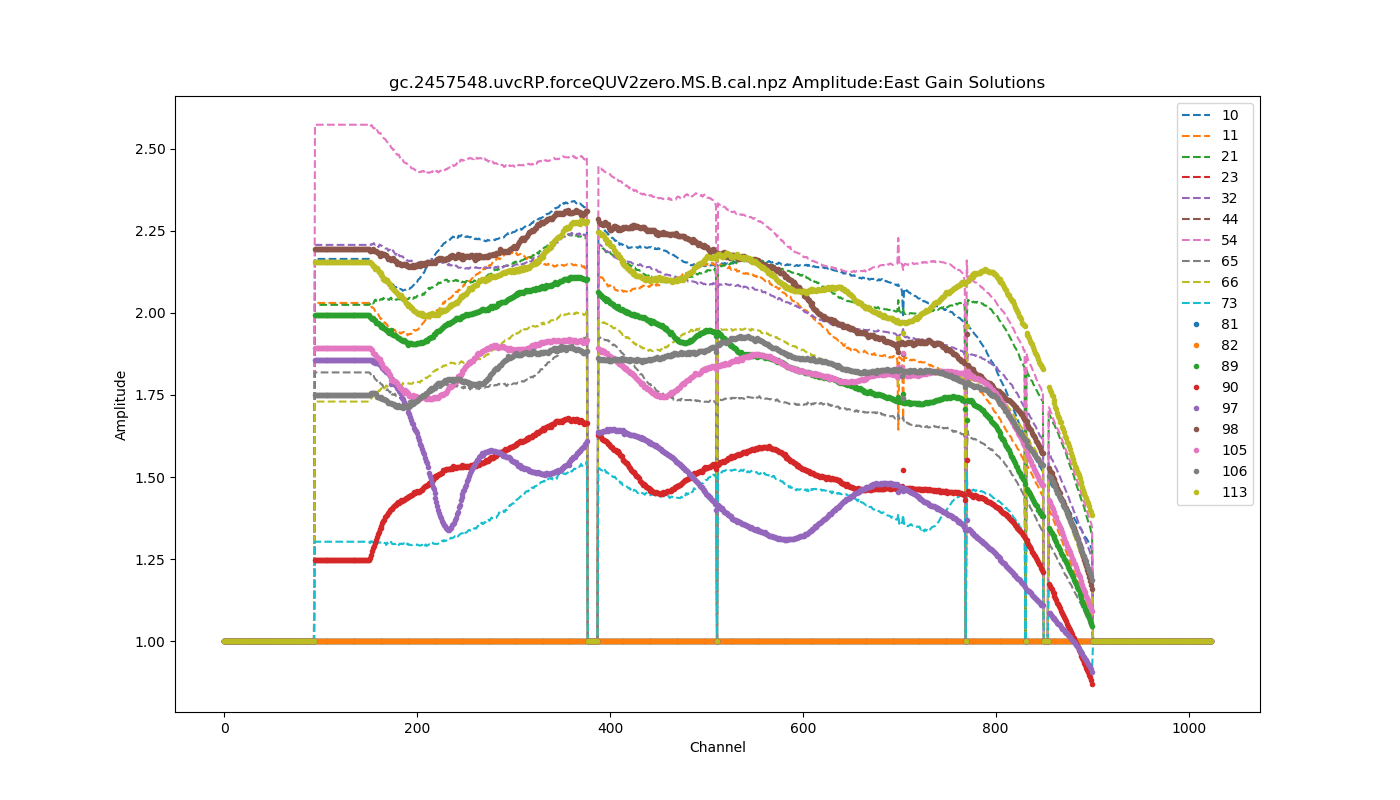

In [18]:
Image(filename="amp_east_gc.2457548.uvcRP.forceQUV2zero.MS.B.cal.npz.png")

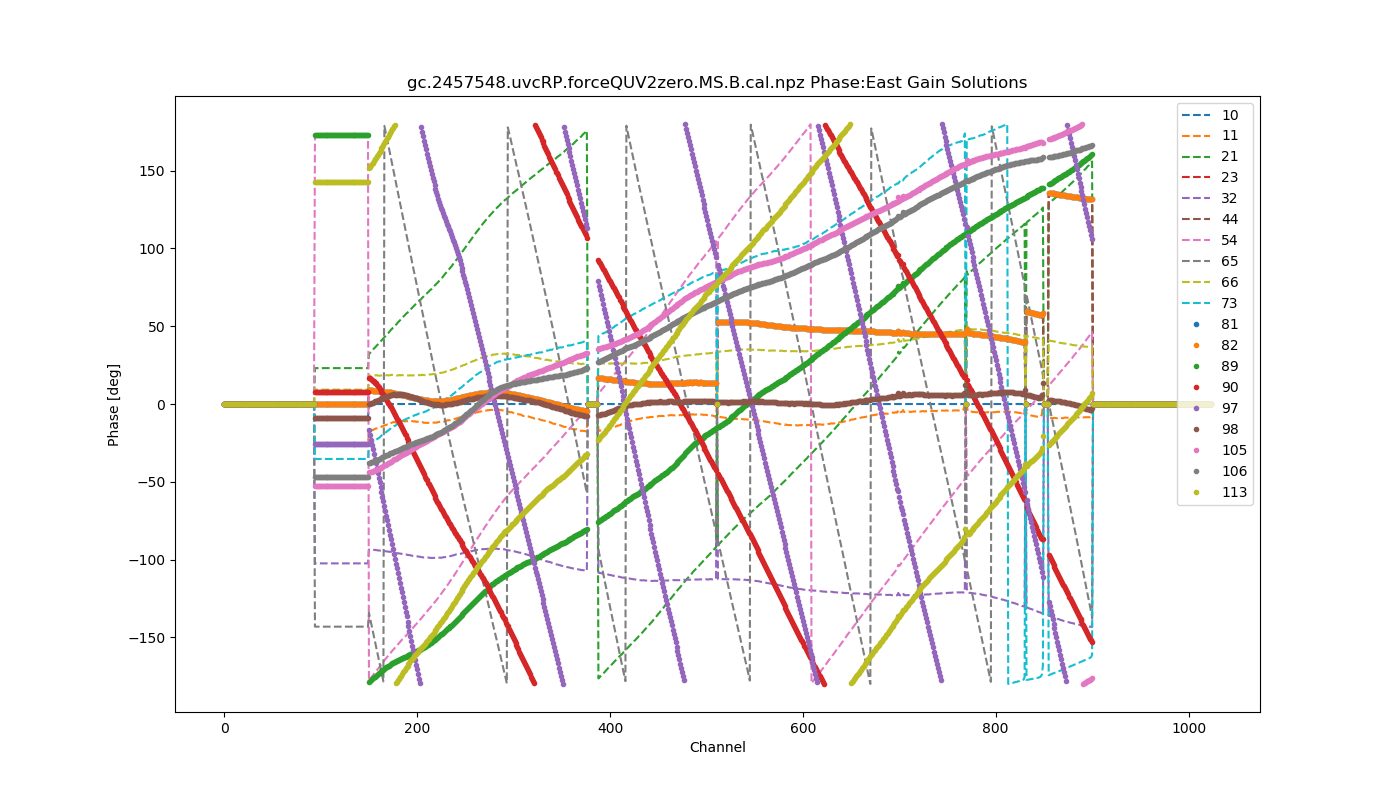

In [19]:
Image(filename="phase_east_gc.2457548.uvcRP.forceQUV2zero.MS.B.cal.npz.png")

### Generate Channel by Channel Image

In CASA you use the CLEAN task to to generate this image and then convert it to a fits file. Use the following commands in CASA:

In [ ]:
# In CASA command line

msname = 'gc.2457548.uvcRP.forceQUV2zero.MS' # Name of calibrated MS file.

fitsname = 'mult_spec_1024_chan_'+msname[:-3]+'.image.fits'
imagename = 'mult_spec_1024_chan_'+msname[:-3]+'.image'
    
clean(msname,imagename[:-6],niter=0,weighting = 'briggs',robust =0
      ,imsize =[512 ,512],cell=['500 arcsec'],phasecenter = 'J2000 17h45m40.0409s -29d0m28.118s'
      ,mode='channel',nterms =1,spw='0',nchan=1024, start=0, width=1
      ,stokes='IQUV', interactive=False, npercycle=5, threshold='0.1mJy/beam')
exportfits(imagename,fitsname)

viewer(imagename) # View image and extract ra/dec of the GC

### Build Spectrum

Then use the following python script to build your spectrum, then write real_spec/sim_spec as another npz file. You'll use this to calculate the scaling spectrum after you've made the multispectrum images of the real and simulated data.

In [ ]:
# In python

ra, dec = 269,251 # ra/dec for real data
sim_ra,sim_dec = 268,259 #ra/dec for sim data

spect_realdata = fits.open(args.fits_multspec) #(4, 1024, 512, 512)
spect_simdata = fits.open(args.sim_fits_multspec) #(4, 1024, 512, 512)

#Find the spectrum need to scale the visibilities
spect_factor = spect_realdata[0].data[0,:,ra,dec]/ spect_simdata[0].data[0,:,sim_ra,sim_dec] # (1024,)
nan_index = np.argwhere(np.isnan(spect_factor))[:,0].tolist() # look for any nans
spect_factor[nan_index]=0 # If they exist set them to zero
np.savez("SpectrumScale_realOVERsim.npz", SpectrumScale =spect_factor)# Save them as a separate file

### RESULT
The ratio and Smoothed version should look something like this. This is Real/Simulation.

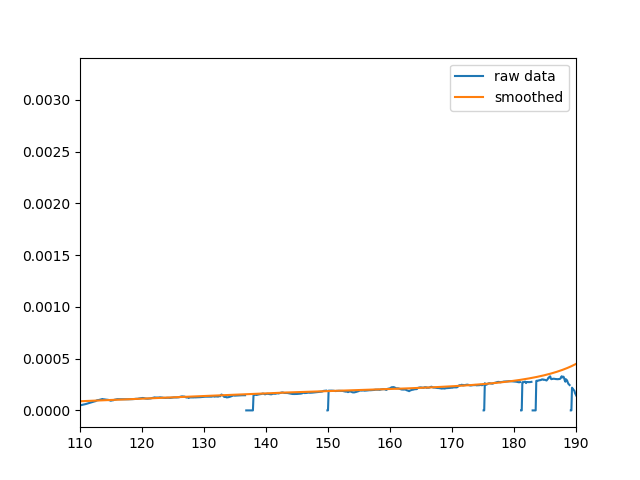

In [21]:
Image(filename='ratio_comparison.png')

### Absolute Calibration Process

Now we will start the abscal process by converting the cal files and npz files to hdf5 files. I used a script called abscal_commands.py but I will explicitly write out the values I used for the arguments. 

### Convert New Miriad File to uvfits file

In python you can convert the miriad to uvfits. Convert to a MS and CLEAN the image. I chose to keep the dirty image and converted it to a .FITS file

Then you can use ds9 to quickly generate an image of your stokes parameters.

In [ ]:
# Convert Miriad file to uvfits
uv = UVData()
uv.read_miriad("gc.2457548.uvcRP.abscal.uvcRP")
uv.write_uvfits('gc.2457548.uvcRP.abscal.uvcRP.uvfits',spoof_nonessential=True,force_phase=True)

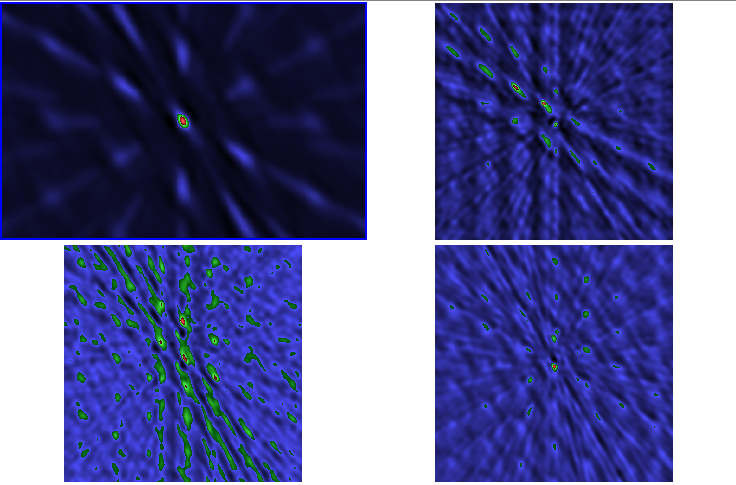

In [27]:
Image(filename="ds9im.png")

In [26]:
pwd

u'/data4/paper/HERA19Golden/RawData/2457548/forceQUV2Zero/pleasework'